# Traded Climate Stress - calories

In [1]:
# __authors__: Elizabeth Barnes, Patrick W. Keys, Noah Diffenbaugh, Tom Hertel, Uris Baldos and Johanna Hedlund
# __date__: September 23, 2023

In [2]:
import warnings
import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cmasher as cmr

import experiment_settings
import data_processing
import plots
import cropstress
import climatedata
import metrics

import palettable
import scipy.stats as stats
import cartopy as ct
from matplotlib.colors import ListedColormap
import matplotlib as mpl

warnings.filterwarnings("ignore")

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
FS = 10
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
plt.rc("savefig", facecolor="white")
plt.rc("axes", facecolor="white")
plt.rc("axes", labelcolor="dimgrey")
plt.rc("axes", labelcolor="dimgrey")
plt.rc("xtick", color="dimgrey")
plt.rc("ytick", color="dimgrey")
map_proj = ct.crs.EqualEarth(central_longitude=0.0)

In [3]:
DATA_DIRECTORY = "/Users/eabarnes/big_data/"
PROCESSED_DIRECTORY = "processed_data/"
FIGURE_DIRECTORY = "figures/"
SHAPE_DIRECTORY = "shapefiles/gadm_shapefiles_20230301_gtapv11/"
CROP_DIRECTORY = "data/cropland/regridded_cropland/"
POPULATION_DIRECTORY = "data/population/SSP2/Total/NetCDF/"
PROCESSED_METRICS_DIRECTORY = "processed_metrics/"
SAVE_DATA = True
REWRITE = True

EXP_NAME = "exp300"

## PERFORM ANALYSIS

In [4]:
# GET THE MASKS
settings = experiment_settings.get_settings(EXP_NAME)
crop_name = cropstress.crop_name(settings["product"])
mask_country, regs_shp = data_processing.get_country_masks(
    settings, SHAPE_DIRECTORY, DATA_DIRECTORY
)

loading shapefiles/gadm_shapefiles_20230301_gtapv11/countries_10m_cesm2.nc


In [5]:
# LOOP THROUGH PREVIOUS ANALYSIS
imp.reload(cropstress)
imp.reload(metrics)

reporter_import_calories_sum = None
traded_stress_calories = None

for subexp in settings["subexperiments"]:
    print(subexp)
    pass_settings = experiment_settings.get_settings(subexp)
    data = climatedata.get_climate_data(pass_settings, rewrite=False, save=False)

    # get analyzed stress
    (
        __,
        traded_stress,
        __,
        __,
        __,
    ) = cropstress.get_processed_metrics(None, pass_settings, rewrite=False, save=False)

    # combine subexperiment via calories to one traded_stress by calories matrix
    data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
        pass_settings, convert_to_calories=True
    )

    reporter_import_calories = np.zeros(len(reporter_code_list))
    for irep, reporter_code in enumerate(reporter_code_list):
        data_reporter = data_trade[data_trade["Destination"] == reporter_code]
        reporter_import_calories[irep] = data_reporter["TotValue"].sum()

    if reporter_import_calories_sum is None:
        reporter_import_calories_sum = reporter_import_calories
        traded_stress_calories = (
            traded_stress * reporter_import_calories[:, np.newaxis, np.newaxis]
        )
    else:
        reporter_import_calories_sum = (
            reporter_import_calories_sum + reporter_import_calories
        )
        traded_stress_calories = (
            traded_stress_calories
            + traded_stress * reporter_import_calories[:, np.newaxis, np.newaxis]
        )

# get traded_stress = [reporter, ens_member, partern]
traded_stress = (
    traded_stress_calories / reporter_import_calories_sum[:, np.newaxis, np.newaxis]
)

# compute correlation metrics
reporter_code_summary = []
metrics_dict = {}
stress_dict = {}

pass_settings["product"] = "all"
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    pass_settings, convert_to_calories=True
)
for irep, reporter_code in enumerate(reporter_code_list):
    # GET REPORTER DATA
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    partner_code_list = data_reporter["Source"].values
    calories = data_reporter["TotValue"].values

    # SUMMARIZING METRICS
    total_stress = np.nansum(traded_stress[irep, :, :], axis=-1)
    corr_localimports = metrics.correlation_localimports(
        traded_stress[irep, :, :], reporter_code, partner_code_list
    )
    corr_toptwo = metrics.correlation_toptwo(calories, traded_stress[irep, :, :])
    frac_stress_noself, frac_var_noself = metrics.variance_fraction(
        traded_stress, irep, reporter_code, partner_code_list
    )

    # FILL DICTIONARIES
    stress_dict[reporter_code] = total_stress
    metrics_dict[reporter_code] = {
        "corr_localtotal": corr_localimports,
        "corr_toptwo": corr_toptwo,
        "frac_stress_noself": frac_stress_noself,
        "frac_var_noself": frac_var_noself,
    }

# CONVERT TO DATAFRAMES
df_stress = pd.DataFrame(stress_dict).T
df_metrics = pd.DataFrame(metrics_dict).T

exp301
processed_data/exp201_processed_data.nc: loading saved data.
final samples.shape = (100, 192, 288)
   loading pre-saved data from processed_metrics/exp301_processed_metrics.pickle
reading trade data: data/GTAP_data/2024-01-04_GTAPdata_MUSD_v11b.csv
len(reporter_code_list) = 158
n_partners = 160
exp302
processed_data/exp202_processed_data.nc: loading saved data.
final samples.shape = (100, 192, 288)
   loading pre-saved data from processed_metrics/exp302_processed_metrics.pickle
reading trade data: data/GTAP_data/2024-01-04_GTAPdata_MUSD_v11b.csv
len(reporter_code_list) = 158
n_partners = 160
exp303
processed_data/exp203_processed_data.nc: loading saved data.
final samples.shape = (100, 192, 288)
   loading pre-saved data from processed_metrics/exp303_processed_metrics.pickle
reading trade data: data/GTAP_data/2024-01-04_GTAPdata_MUSD_v11b.csv
len(reporter_code_list) = 158
n_partners = 160
exp304
processed_data/exp204_processed_data.nc: loading saved data.
final samples.shape = (

In [6]:
# THRESHOLD = 0.20
# x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
# imin_member = np.argmin(x.sum(axis=0))
# min_member = np.min(x.sum(axis=0)) / traded_stress.shape[0]
# print(imin_member, (min_member*100).round(1))

# x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
# imax_member = np.argmax(x.sum(axis=0))
# max_member = np.max(x.sum(axis=0)) / traded_stress.shape[0]
# print(imax_member, (max_member*100).round(1))

In [7]:
# Fill the maps

map_summary = data.copy() * 0.0
map_r = np.zeros((data.shape[1], data.shape[2]))
map_rtoptwo = np.zeros((data.shape[1], data.shape[2]))
frac_stress_noself = np.zeros((data.shape[1], data.shape[2]))
frac_var_noself = np.zeros((data.shape[1], data.shape[2]))
map_stress_fracratio_perc = np.zeros((data.shape[1], data.shape[2]))

for irep, reporter_code in enumerate(reporter_code_list):
    mask_reporter = data_processing.create_country_mask(
        reporter_code, regs_shp, mask_country
    )

    map_summary = cropstress.fill_map(
        map_summary, mask_reporter, np.asarray(df_stress.loc[reporter_code])
    )
    map_r = cropstress.fill_map(
        map_r, mask_reporter, df_metrics.loc[reporter_code]["corr_localtotal"]
    )
    map_rtoptwo = cropstress.fill_map(
        map_rtoptwo, mask_reporter, df_metrics.loc[reporter_code]["corr_toptwo"]
    )
    frac_stress_noself = cropstress.fill_map(
        frac_stress_noself,
        mask_reporter,
        df_metrics.loc[reporter_code]["frac_stress_noself"],
    )
    frac_var_noself = cropstress.fill_map(
        frac_var_noself, mask_reporter, df_metrics.loc[reporter_code]["frac_var_noself"]
    )

# finalize map and mask zero to nans
map_summary = xr.where(map_summary == 0.0, np.nan, map_summary)
map_r = xr.where(map_r == 0.0, np.nan, map_r)
map_rtoptwo = xr.where(map_rtoptwo == 0.0, np.nan, map_rtoptwo)
frac_stress_noself = xr.where(frac_stress_noself == 0.0, np.nan, frac_stress_noself)
frac_var_noself = xr.where(frac_var_noself == 0.0, np.nan, frac_var_noself)

In [8]:
raise ValueError()

ValueError: 

## PLOT RESULTS

In [ ]:
imp.reload(plots)
import string
from matplotlib import colors

cmap = palettable.cmocean.sequential.Matter_10.mpl_colormap
cmap_stress = palettable.cmocean.sequential.Amp_10.mpl_colormap
cmap_trade = palettable.cmocean.sequential.Speed_20.mpl_colormap

# ------------------------
THRESHOLD = 0.20
# compute the worst and best case scenarios
x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
imin_member = np.argmin(x.sum(axis=0))
min_member = np.min(x.sum(axis=0)) / traded_stress.shape[0]
print(imin_member, (min_member * 100).round(1))

x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
imax_member = np.argmax(x.sum(axis=0))
max_member = np.max(x.sum(axis=0)) / traded_stress.shape[0]
print(imax_member, (max_member * 100).round(1))
# ------------------------

members_to_plot = (
    8,
    43,
    imax_member,
    imin_member,
)

vscale = 100.0
norm = colors.BoundaryNorm(np.arange(0.0, vscale + 10, 10), cmap.N)

n_plot_members = len(members_to_plot)
fig = plt.figure(figsize=(4.75 * 2.0, 3.0 * 1.75), dpi=150)

for isample, sample in enumerate(members_to_plot):
    ax = fig.add_subplot(2, 2, isample + 1, projection=map_proj)
    plots.drawOnGlobe(
        ax,
        map_proj,
        data=map_summary[sample, :, :] * 100,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=0.0,
        vmax=vscale,
        cbarBool=False,
        extent="neither",
        norm=norm,
    )
    ax.set_title(
        "["
        + string.ascii_uppercase[isample]
        + "] Member \#"
        + str(data[sample]["sample"]["member"].values)
    )

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_summary_imported_stress"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure2_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_summary_imported_stress",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
from matplotlib import colors

cmap = palettable.cmocean.sequential.Matter_10.mpl_colormap
cmap_stress = palettable.cmocean.sequential.Amp_10.mpl_colormap
cmap_trade = palettable.cmocean.sequential.Speed_20.mpl_colormap

members_to_plot = (
    0,
    10,
    np.argmax(np.nanmean(np.nansum(traded_stress, axis=(2,)), axis=0)),
    np.argmin(np.nanmean(np.nansum(traded_stress, axis=(2,)), axis=0)),
)
vscale = 1.0
norm = colors.BoundaryNorm(np.arange(0.0, vscale + 0.1, 0.1), cmap.N)

n_plot_members = len(members_to_plot)
fig = plt.figure(figsize=(10.0 * 2.0, 3.0), dpi=200)

for isample, sample in enumerate(members_to_plot):
    ax = fig.add_subplot(1, 4, isample + 1, projection=map_proj)
    plots.drawOnGlobe(
        ax,
        map_proj,
        data=map_summary[sample, :, :],
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=0.0,
        vmax=vscale,
        cbarBool=True,
        extent="neither",
        norm=norm,
    )
    ax.set_title(crop_name + ": fraction of imports under stress")
    plt.text(
        0.0,
        1.0,
        "year: "
        + str(data[sample]["sample"]["window"].values)
        + "\nmember: "
        + str(data[sample]["sample"]["member"].values),
        color="gray",
        transform=ax.transAxes,
        fontsize=6,
        va="top",
    )

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_summary_imported_stress"
)
plt.show()

In [ ]:
# imp.reload(plots)
# from matplotlib import colors

# # cmap_corr = colors.ListedColormap(palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors)
# cmap_corr = plt.get_cmap("twilight_shifted", 11)
# fig = plt.figure(figsize=(5.0 * 2.0 * 1.25, 3.0 * 1 * 1.25), dpi=200)
# vscale = 0.55

# ax = fig.add_subplot(1, 3, 1, projection=map_proj)
# plots.drawOnGlobe(
#     ax,
#     map_proj,
#     data=map_rtoptwo,
#     lats=data.lat,
#     lons=data.lon,
#     fastBool=True,
#     cmap=cmap_corr,
#     vmin=-vscale,
#     vmax=vscale,
#     cbarBool=True,
#     extent="neither",
# )
# ax.set_title("[A] Correlation of climate-stressed calories\nfrom top two suppliers")


# ax = fig.add_subplot(1, 3, 2, projection=map_proj)
# plots.drawOnGlobe(
#     ax,
#     map_proj,
#     data=map_r,
#     lats=data.lat,
#     lons=data.lon,
#     fastBool=True,
#     cmap=cmap_corr,
#     vmin=-vscale,
#     vmax=vscale,
#     cbarBool=True,
#     extent="neither",
# )
# ax.set_title(
#     "[B] Correlation of climate-stressed calories\nbetween domestic and non-domestic suppliers"
# )

# ax = fig.add_subplot(1, 3, 3, projection=map_proj)
# cb, __ = plots.drawOnGlobe(
#     ax,
#     map_proj,
#     data=frac_stress_noself,
#     lats=data.lat,
#     lons=data.lon,
#     fastBool=True,
#     cmap=cmr.get_sub_cmap("inferno_r", 0.0, 0.75, N=10),
#     vmin=0,
#     vmax=1.0,
#     cbarBool=True,
#     extent="neither",
# )
# cb.set_ticks(np.arange(0, 1.2, 0.2))
# cb.set_ticklabels(("0", "0.2", "0.4", "0.6", "0.8", "1.0"))
# ax.set_title("[C] Mean fraction of climate-stressed calories\nfrom non-domestic suppliers")

# # ax = fig.add_subplot(2, 2, 4, projection=map_proj)
# # cb, __ = plots.drawOnGlobe(
# #     ax,
# #     map_proj,
# #     data=frac_var_noself,
# #     lats=data.lat,
# #     lons=data.lon,
# #     fastBool=True,
# #     cmap=cmr.get_sub_cmap("inferno", 0.25, 1.0, N=10),
# #     vmin=0,
# #     vmax=0.5,
# #     cbarBool=True,
# #     extent="max",
# # )
# # cb.set_ticks(np.arange(0, 0.6, 0.1))
# # cb.set_ticklabels(("0", "0.1", "0.2", "0.3", "0.4", "0.5+"))
# # ax.set_title(
# #     "[D] Fractional variance of climate-stressed calories\nfrom non-local suppliers"
# # )

# plt.tight_layout()
# plots.savefig(
#     FIGURE_DIRECTORY
#     + settings["exp_name"]
#     + "_"
#     + settings["product"]
#     + "_imported_local_stress_metrics"
# )
# plots.savefig(
#     FIGURE_DIRECTORY
#     + "figure4_"
#     + settings["exp_name"]
#     + "_"
#     + settings["product"]
#     + "_imported_local_stress_metrics",
#     fig_format=(".png", ".pdf"),
# )
# plt.show()

In [ ]:
# imp.reload(plots)
# from matplotlib import colors

# # cmap_corr = colors.ListedColormap(palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors)
# cmap_corr = plt.get_cmap("twilight_shifted", 11)
# # fig = plt.figure(figsize=(5.0 * 2.0 * 1.25/3 * 2 * 2, 3.0 * 1 * 1.25 * 2), dpi=200)
# fig = plt.figure(figsize=(4.75 * 2.0, 3.0 * 1.75), dpi=150)
# vscale = 0.55

# # ax = fig.add_subplot(1, 3, 1, projection=map_proj)
# # plots.drawOnGlobe(
# #     ax,
# #     map_proj,
# #     data=map_rtoptwo,
# #     lats=data.lat,
# #     lons=data.lon,
# #     fastBool=True,
# #     cmap=cmap_corr,
# #     vmin=-vscale,
# #     vmax=vscale,
# #     cbarBool=True,
# #     extent="neither",
# # )
# # ax.set_title("[A] Correlation of climate-stressed calories\nfrom top two suppliers")


# ax = fig.add_subplot(1, 2, 2, projection=map_proj)
# plots.drawOnGlobe(
#     ax,
#     map_proj,
#     data=map_r,
#     lats=data.lat,
#     lons=data.lon,
#     fastBool=True,
#     cmap=cmap_corr,
#     vmin=-vscale,
#     vmax=vscale,
#     cbarBool=True,
#     extent="neither",
# )
# ax.set_title(
#     "[B] Correlation of climate-stressed calories\nbetween local and non-local suppliers"
# )

# ax = fig.add_subplot(1, 2, 1, projection=map_proj)
# cb, __ = plots.drawOnGlobe(
#     ax,
#     map_proj,
#     data=frac_stress_noself,
#     lats=data.lat,
#     lons=data.lon,
#     fastBool=True,
#     cmap=cmr.get_sub_cmap("inferno_r", 0.0, 0.75, N=10),
#     vmin=0,
#     vmax=1.0,
#     cbarBool=True,
#     extent="neither",
# )
# cb.set_ticks(np.arange(0, 1.2, 0.2))
# cb.set_ticklabels(("0", "0.2", "0.4", "0.6", "0.8", "1.0"))
# ax.set_title("[A] Mean fraction of climate-stressed calories\nfrom non-local suppliers")

# # ax = fig.add_subplot(2, 2, 4, projection=map_proj)
# # cb, __ = plots.drawOnGlobe(
# #     ax,
# #     map_proj,
# #     data=frac_var_noself,
# #     lats=data.lat,
# #     lons=data.lon,
# #     fastBool=True,
# #     cmap=cmr.get_sub_cmap("inferno", 0.25, 1.0, N=10),
# #     vmin=0,
# #     vmax=0.5,
# #     cbarBool=True,
# #     extent="max",
# # )
# # cb.set_ticks(np.arange(0, 0.6, 0.1))
# # cb.set_ticklabels(("0", "0.1", "0.2", "0.3", "0.4", "0.5+"))
# # ax.set_title(
# #     "[D] Fractional variance of climate-stressed calories\nfrom non-local suppliers"
# # )

# plt.tight_layout()
# plots.savefig(
#     FIGURE_DIRECTORY
#     + settings["exp_name"]
#     + "_"
#     + settings["product"]
#     + "_imported_local_stress_metrics"
# )
# plots.savefig(
#     FIGURE_DIRECTORY
#     + "figure4_"
#     + settings["exp_name"]
#     + "_"
#     + settings["product"]
#     + "_imported_local_stress_metrics",
#     fig_format=(".png", ".pdf"),
# )
# plt.show()

In [ ]:
# raise ValueError()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

imp.reload(plots)
from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(
    [
        "gold",
        "mediumpurple",
        "sandybrown",
        "mediumseagreen",
        "mediumblue",
        "crimson",
        "sienna",
    ]
)

x_data = np.nansum(traded_stress, axis=-1)
x_data = x_data.swapaxes(1, 0)
# x_data[x_data < .3] = 0.
# x_data = np.where(x_data == 0, np.nan, x_data)

model = []
model_full = AgglomerativeClustering(
    n_clusters=None,
    metric="euclidean",
    linkage="ward",
    distance_threshold=0.0,
    compute_full_tree=True,
).fit(x_data)
model = AgglomerativeClustering(
    n_clusters=7, metric="euclidean", linkage="ward", distance_threshold=None
).fit(x_data)
n_clusters = len(np.unique(model.labels_))
classes = model.labels_

# classes[classes == 6] = 100
# classes[classes == 5] = 6
# classes[classes == 6] = 5

if settings["gcm"] == "mpi":
    color_threshold = 4.25
else:
    color_threshold = 4.0

plt.figure(figsize=(12 * 0.8, 4 * 0.8))
__, linkage_matrix = plots.plot_dendrogram(
    model_full,
    truncate_mode=None,
    color_threshold=color_threshold,
    get_leaves=True,
    distance_sort="ascending",
    above_threshold_color="gray",
    leaf_rotation=-90,
)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.yticks([])
plt.xlabel("member")
plt.tight_layout()


plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_dendrogram_" + settings["product"]
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure6_a"
    + settings["exp_name"]
    + "_dendrogram_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
# PLOT THE RESULTS
vmin, vmax = 0.0, 60.0
multiplier = 100
cmap = palettable.cubehelix.cubehelix1_16_r.mpl_colors
cmap = ListedColormap(cmap[0:-2])
# norm = colors.BoundaryNorm(np.arange(vmin, vmax + 0.1 * multiplier, 0.1 * multiplier), cmap.N)

# fig = plt.figure(figsize=(4.375 * n_clusters, 3.0), dpi=200)
fig = plt.figure(figsize=(4.375 * 3.0, 3.0 * 2.5), dpi=150)
for icluster in range(n_clusters):
    j = np.where(classes == icluster)[0]

    ax = fig.add_subplot(3, 3, icluster + 1, projection=map_proj)

    data_plot = np.median(map_summary[j, :, :], axis=0)
    # data_plot = map_summary[j, :, :]
    # data_plot = xr.where(data_plot<0.3, 0., data_plot)
    # data_plot = data_plot.median(axis=0)

    cb, image = plots.drawOnGlobe(
        ax,
        map_proj,
        data=data_plot * multiplier,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # norm=norm,
        cbarBool=False,
        extent="max",
    )
    # cb.ax.set_xlabel("\% under stress")
    # cb.ax.tick_params(labelsize=6)
    # ax.set_title(f"{crop_name}: cluster {icluster}; N = {len(j)}")
    ax.set_title(f"Cluster {icluster+1}, N = {len(j)}")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_summary_"
    + settings["product"]
    + "_clusters"
    + str(n_clusters)
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure6_"
    + settings["exp_name"]
    + "_summary_"
    + settings["product"]
    + "_clusters"
    + str(n_clusters),
    fig_format=(".png", ".pdf"),
)
# plt.close()
plt.show()

In [ ]:
# PLOT SPECIFIC GROUPS OF CLUSTERS
imp.reload(plots)
# vmin, vmax = 0.0, 0.75
# multiplier = 100
vmin, vmax = 0.0, 60.0
multiplier = 100
cmap = palettable.cubehelix.cubehelix1_16_r.mpl_colors
cmap = ListedColormap(cmap[0:-1])
# norm = colors.BoundaryNorm(np.arange(vmin, vmax + 0.1 * multiplier, 0.1 * multiplier), cmap.N)

# samples = [99,40,62]
# samples = [0, 23, 24, 59, 61, 85]
# samples = [50, 68, 93]
# samples = [97, 34, 75]
# samples = [85, 80, 99, 62, 28, 56]
cluster_to_plot = 0
samples = np.where(classes == cluster_to_plot)[0]
fig = plt.figure(figsize=(4.375 * 3.0, 3.0 * 2.5), dpi=150)
for isample, sample in enumerate(samples):
    ax = fig.add_subplot(3, 3, isample + 1, projection=map_proj)

    data_plot = map_summary[sample, :, :]

    cb, image = plots.drawOnGlobe(
        ax,
        map_proj,
        data=data_plot * multiplier,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # norm=norm,
        cbarBool=False,
        extent="max",
    )
    # cb.ax.set_xlabel("fraction under stress")
    # cb.ax.tick_params(labelsize=6)
    # ax.set_title(f"{crop_name}: Sample {sample}")
    ax.set_title(f"Member \#{sample}")

plt.tight_layout()

plots.savefig(
    FIGURE_DIRECTORY
    + "figure6_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_cluster"
    + str(cluster_to_plot),
    fig_format=(".png", ".pdf"),
)

plt.show()

In [ ]:
import metrics
import seaborn as sns

imp.reload(cropstress)
imp.reload(metrics)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)
plot_list = ("usa", "are", "chn", "esp", "rus", "fra", "bra", "zaf", "eth", "mex")

f, axs = plt.subplots(2, 5, figsize=(5 * 5, 5 * 2))
axs = axs.flatten()
fig_counter = 0

for irep, reporter_code in enumerate(reporter_code_list):
    if reporter_code not in plot_list:
        continue

    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    reporter_name = data_processing.get_name_from_code(
        (data_reporter["Destination"].values[0],)
    )
    partner_code_list = data_reporter["Source"].values

    ip = np.where(partner_code_list == reporter_code)[0]
    x = np.squeeze(traded_stress[irep, :, ip])

    ip_y = np.where(partner_code_list != reporter_code)[0]
    y = np.nansum(traded_stress[irep, :, ip_y].T, axis=-1)  # excluding self
    # y = df_stress.loc[reporter_code].values  # includes self (can just subtract x to exclude self)

    # compute metrics
    r = metrics.correlation_localimports(
        traded_stress[irep, :, :], reporter_code, partner_code_list
    )
    severe_ratio, severe_ratio_perc = metrics.stress_fraction_ratios(
        y, x, perc=75, frac=0.1
    )

    fig_counter += 1
    ax = axs[fig_counter - 1]
    ax.plot(x, y, ".", markersize=9, alpha=0.6, color="tab:purple")
    ax.set_title(
        crop_name
        + ": "
        + reporter_name
        + ": r="
        + str(np.round(r, 2))
        + ", stress_ratio="
        + str(np.round(severe_ratio, 2))
    )
    ax.set_ylabel("fraction crop stressed from imports(excluding self)")
    ax.set_xlabel("fraction crop stressed from self-imports")
    ax.set_xlim(-0.01, 0.8)
    ax.set_ylim(-0.01, 0.8)
    ax.set_box_aspect(1)

f.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_scatter_local_imports_"
    + settings["product"]
)
plt.show()

In [ ]:
import metrics
import seaborn as sns

imp.reload(cropstress)
imp.reload(metrics)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)
plot_list = ("usa", "are", "chn", "esp", "rus", "fra", "bra", "zaf", "ukr", "mex")


f, ax = plt.subplots(1, 1, figsize=(6 * 1, 6 * 1))
fig_counter = 0

for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    reporter_name = data_processing.get_name_from_code(
        (data_reporter["Destination"].values[0],)
    )
    partner_code_list = data_reporter["Source"].values

    ip = np.where(partner_code_list == reporter_code)[0]
    x = np.squeeze(traded_stress[irep, :, ip])

    ip_y = np.where(partner_code_list != reporter_code)[0]
    y = np.nansum(traded_stress[irep, :, ip_y].T, axis=-1)  # excluding self

    # compute metrics
    r = metrics.correlation_localimports(
        traded_stress[irep, :, :], reporter_code, partner_code_list
    )
    severe_ratio, severe_ratio_perc = metrics.stress_fraction_ratios(
        y, x, perc=75, frac=0.1
    )
    if severe_ratio == 0.0:
        continue
    ax.plot(severe_ratio, r, ".", markersize=9, alpha=0.4, color="tab:purple")
    ax.annotate(reporter_name, (severe_ratio, r), fontsize=4)

    if severe_ratio > 10:
        print(reporter_name)

# plt.xlim(0, 7)
plt.axhline(y=0, linewidth=0.5, color="gray", alpha=0.5)
plt.axvline(x=1, linewidth=0.5, color="gray", alpha=0.5)
plt.ylabel("correlation of local and imported fraction of crops stressed")
plt.xlabel(
    "ratio (local to imported) of the frequency more than 10$\%$ of the crop is stressed"
)
f.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_quadrantscatter_" + settings["product"]
)
plt.show()

In [ ]:
max_values = np.max(df_stress.values, axis=-1)
irep_sorted = np.argsort(max_values)[::-1]

plt.figure(figsize=(15, 6))
y_count = -1
rep_name_list = []
for index in range(len(irep_sorted)):
    irep = irep_sorted[index]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )
    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    plt.bar(
        y_count,
        np.max(df_stress.iloc[irep, :].values, axis=-1),
        alpha=0.15,
        color="tab:purple",
    )
    plt.plot(
        np.ones(
            100,
        )
        * y_count,
        df_stress.loc[reporter_code_list[irep]].values,
        "_",
        color="tab:purple",
        markersize=4,
        alpha=0.85,
    )
    plt.annotate(
        rep_name, (y_count - 0.25, max_values[irep] + 0.01), fontsize=4, rotation=90
    )

plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=4, rotation=90)
plt.xlim(-2, len(np.asarray(rep_name_list)) + 1)
plt.ylim(0, 1.19)
plt.ylabel("fraction of total imported crop stressed")
plt.title(crop_name + " stress for " + str(df_stress.shape[1]) + " storylines")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().yaxis.set_tick_params(width=1, length=7, direction="in")

# plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_ladder_" + settings["product"]
)
plt.show()

In [ ]:
selected_countries = [
    "Armenia",
    # "Chad",
    "Nigeria",
    "China",
    "Panama",
    "Nepal",
    "Finland",
    "South Africa",
    "Venezuela",
    "United States of America",
    "Germany",
    "United Arab Emirates",
    "New Zealand",
]

max_values = np.max(df_stress.values, axis=-1)
irep_sorted = np.argsort(max_values)[::-1]

plt.figure(figsize=(10, 4))
y_count = -1
rep_name_list = []
x_plot = np.zeros((len(selected_countries), 100))
for index in range(len(irep_sorted)):
    irep = irep_sorted[index]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name not in selected_countries:
        continue

    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    # plt.bar(y_count, np.max(df_stress.iloc[irep, :].values, axis=-1), alpha=0.15, color="tab:purple")
    x_plot[y_count, :] = df_stress.loc[reporter_code_list[irep]].T
    # if rep_name=="Nigeria":
    #     raise ValueError()

# sns.violinplot(x=np.arange(0,10), y=x_plot.T, ax=plt.gca(), color="tab:purple", alpha=0.85, inner="stick")
sns.violinplot(
    data=x_plot.T * 100,
    ax=plt.gca(),
    color="gold",
    alpha=0.85,
    inner="stick",
    scale="width",
    cut=0,
    linewidth=0.75,
    linecolor="k",
)

plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=8, rotation=45)
plt.xlim(-0.5, len(np.asarray(rep_name_list)))
plt.ylim(0, 100.0)
plt.ylabel("\% of crop supply that is stressed")
# plt.title(crop_name + " stress for " + str(df_stress.shape[1]) + " storylines")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().yaxis.set_tick_params(width=1, length=7, direction="in")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_ladderSelected_" + settings["product"]
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure3_"
    + settings["exp_name"]
    + "_ladderSelected_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
# import scipy

# settings_2024 = experiment_settings.get_settings("exp201")
# (
#     __,
#     __,
#     __,
#     df_stress_2024,
#     df_metrics_2024,
# ) = cropstress.get_processed_metrics(np.nan, settings_2024, rewrite=False, save=False)

# region = "arm"
# x = df_stress.loc[region]
# bins = np.arange(0, 1, 0.05)
# kde = scipy.stats.gaussian_kde(x)
# y = kde.evaluate(bins)

# x2024 = df_stress_2024.loc[region]
# kde = scipy.stats.gaussian_kde(x2024)
# y2024 = kde.evaluate(bins)

# plt.hist(x, bins=bins, density=False, weights=np.ones_like(x) / len(x))
# plt.plot(bins, y, label="2045", color="tab:purple")
# plt.plot(bins, y2024, label="2024")
# plt.legend()
# plt.show()

In [ ]:
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)

rep_name_list = []
for irep, reporter_code in enumerate(reporter_code_list):
    if reporter_code != "gbr":
        continue

    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    partner_code_list = data_reporter["Source"].values
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name.find("Rest of") == 0:
        continue
    else:
        rep_name_list.append(rep_name)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # compute metrics
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])
    j_top = j_sort[np.where(cumsum < 0.95)[0]]
    if len(j_top) == 0:
        j_top = [
            j_sort[0],
        ]

    x = traded_stress[irep, :, j_top]
    if x.shape[0] == 100:
        x = x.T
    x[x < 0.001] = np.nan

    plt.figure(figsize=(15, 5))
    plt.pcolor(x, cmap="RdPu")
    plt.clim(0, 0.4)
    plt.xlabel("storyline number")
    plt.yticks(
        np.arange(0, len(j_top)) + 0.5,
        data_processing.get_name_from_code(partner_code_list[j_top]),
        fontsize=8,
    )
    plt.colorbar()
    plt.show()

In [ ]:
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)

n_partners = []
max_val = []
cum_two = []
corr_toptwo = []
rep_name_list = []
for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # compute metrics
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])
    top_index = np.where(cumsum <= 0.95)[0]
    if len(top_index) == 0:
        j_top = [
            j_sort[0],
        ]
    else:
        j_top = j_sort[: (top_index[-1] + 1) + 1]

    n_partners.append(len(j_top))
    # max_val.append(np.max(df_stress.loc[reporter_code]))
    max_val.append(np.percentile(df_stress.loc[reporter_code], 100))
    cum_two.append(cumsum[1])
    corr_toptwo.append(df_metrics.loc[reporter_code]["corr_toptwo"])

n_partners = np.asarray(n_partners)
max_val = np.asarray(max_val)
cum_two = np.asarray(cum_two)
corr_toptwo = np.asarray(corr_toptwo)
corr_toptwo = np.where(n_partners > 1, corr_toptwo, np.nan)
# n_partners = np.where(n_partners>1, n_partners, np.nan)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(cum_two, corr_toptwo, ".", alpha=0.5, markersize=10, color="tab:purple")
plt.axvline(x=0.5, color="gray", linewidth=0.5)
plt.axhline(y=0, color="gray", linewidth=0.5)
for i in range(len(cum_two)):
    plt.annotate(
        rep_name_list[i], (cum_two[i] + 0.0015, corr_toptwo[i]), fontsize=4, va="center"
    )
plt.ylabel("correlation between top two partners")
plt.xlabel("fraction of crop imported from top two")
plt.gca().set_box_aspect(1)

plt.subplot(1, 2, 2)
plt.plot(n_partners, max_val, ".", alpha=0.5, markersize=10, color="orange")
plt.xlabel("number of major import partners")
plt.ylabel("worst case storyline (fraction that is stressed)")
for i in range(len(n_partners)):
    plt.annotate(
        rep_name_list[i], (n_partners[i] + 0.0015, max_val[i]), fontsize=4, va="center"
    )
plt.ylim(0, 1)
plt.gca().set_box_aspect(1)

plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_partnerscatter_" + settings["product"]
)
plt.show()

# plt.figure(figsize=(16,4))
# plt.plot(range(len(rep_name_list)), n_partners, '.')
# plt.ylabel("number of major partners")
# plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=4, rotation=90)
# plt.show()

In [ ]:
# Regrid the population data
# for yr in (2010, 2020, 2030):
#     data_pop_regrid = data_processing.get_population(POPULATION_DIRECTORY + "ssp2_" + str(yr) + ".nc", mask_reporter)
#     data_pop_regrid.to_netcdf(POPULATION_DIRECTORY + "/ssp2_" + str(yr) + "_regrid_" + settings["gcm"] + ".nc")

# Major Figures

reading trade data: data/GTAP_data/2024-01-04_GTAPdata_MUSD_v11b.csv
len(reporter_code_list) = 158
n_partners = 160
['nga' 'usa']
Australia
Benin
Burkina Faso
Bolivia
Brazil
Central African Republic
Canada
Cameroon
Congo the Democratic Republic of the
Comoros
Ethiopia
Finland
Ghana
Equatorial Guinea
Greece
Indonesia
India
Iraq
Kazakhstan
Cambodia
Lao People's Democratic Republic
Madagascar
Mali
Malawi
Niger
Pakistan
Panama
Paraguay
State of Palestine
Russian Federation
Chad
Togo
United States of America
Rest of South and Central Africa
Rest of North America
Rest of South Asia
Rest of Southeast Asia
Rest of Former Soviet Union
Rest of Western Africa
Zambia


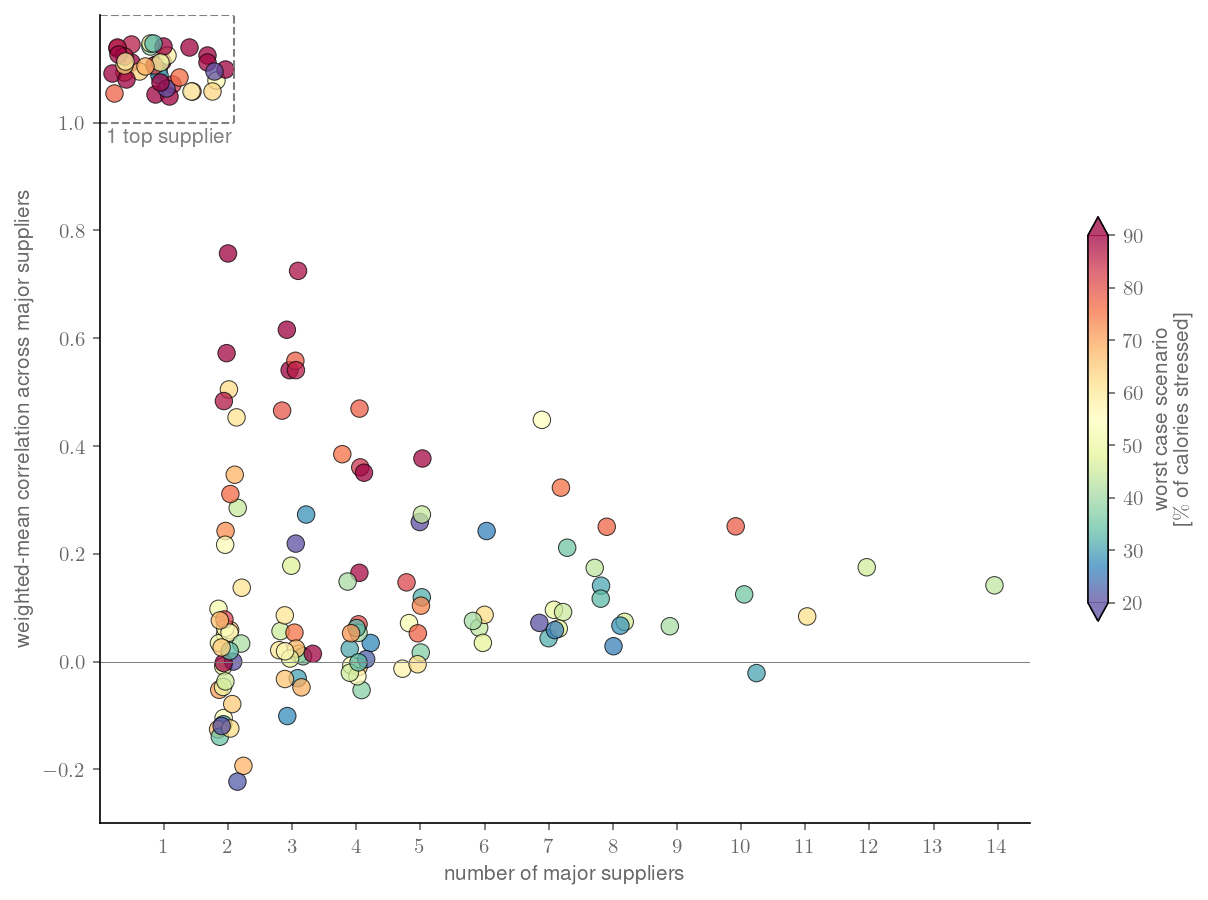

In [11]:
imp.reload(plots)

TOP_THRESHOLD = 0.9
y_count = -1

data_pop = xr.load_dataarray(
    POPULATION_DIRECTORY + "ssp2_2020_regrid_" + settings["gcm"] + ".nc"
)
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)

n_partners_vec = []
corr_top = []
max_val = []
min_val = []
pop_vec = []
rep_name_list = []
rep_code_list = []
own_lead_partner = []
for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    # if rep_name != "Croatia":
    #     continue

    # if rep_name.find("Rest of") == 0:
    #     continue
    # else:
    #     y_count = y_count + 1
    #     rep_name_list.append(rep_name)
    #     rep_code_list.append(reporter_code)
    y_count = y_count + 1
    rep_name_list.append(rep_name)
    rep_code_list.append(reporter_code)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # get population data
    mask_reporter = data_processing.create_country_mask(
        reporter_code, regs_shp, mask_country
    )
    pop_vec.append(data_processing.compute_global_sum(data_pop * mask_reporter))

    # compute metrics
    avg_corr = 0.0
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])

    top_index = np.where(cumsum <= TOP_THRESHOLD)[0]
    if len(top_index) == 0:
        j_top = [
            j_sort[0],
        ]
    else:
        j_top = j_sort[: (top_index[-1] + 1) + 1]

    # check if region is its own leading trade partner
    if reporter_code in partner_code_list[j_top]:
        own_lead_partner.append("k")
    else:
        own_lead_partner.append("w")

    if len(j_top) == 1:
        avg_corr = 1.0
    else:
        x = traded_stress[irep, :, j_top]
        # cov = stats.spearmanr(x).correlation
        cov = np.corrcoef(x)
        cov = plots.remove_offdiagonal(cov, remove_diagonal=True)

        avg_corr = 0
        runsum = 0
        for i in range(cov.shape[0]):
            for j in range(cov.shape[1]):
                if np.isnan(cov[i, j]):
                    continue
                dollar_weight = (frac_dollars[i] + frac_dollars[j]) / 2
                # dollar_weight = 1
                avg_corr = avg_corr + cov[i, j] * dollar_weight
                runsum = runsum + dollar_weight
        if runsum == 0:
            avg_corr = 0.0
        else:
            avg_corr = avg_corr / runsum

    n_partners_vec.append(len(j_top))
    corr_top.append(avg_corr)
    max_val.append(np.percentile(df_stress.loc[reporter_code], 100))
    min_val.append(np.percentile(df_stress.loc[reporter_code], 0))

n_partners_vec = np.asarray(n_partners_vec)
corr_top = np.asarray(corr_top)
max_val = np.asarray(max_val)
min_val = np.asarray(min_val)
pop_vec = np.asarray(pop_vec)
own_lead_partner = np.asarray(own_lead_partner)

i_notself = np.where(corr_top != 1)[0]
i_self = np.where(corr_top == 1)[0]

# ------------------------------------------------------------
# MAKE THE PLOT
rng = np.random.default_rng(51)
plt.figure(figsize=(10, 7))
rng_jiggle = rng.normal(size=n_partners_vec.shape[0]) * 0.12
plt.scatter(
    x=n_partners_vec[i_notself] + rng_jiggle[i_notself],
    y=corr_top[i_notself],
    c=max_val[i_notself] * 100,
    alpha=0.75,
    # s=pop_vec[i_notself] / (5e5),
    s=70,
    vmin=20,
    vmax=90,
    cmap="Spectral_r",
    edgecolor="k",  # own_lead_partner[i_notself],
    linewidths=0.5,
)


# ADD SELF POINTS
plt.axhline(y=0, color="gray", linewidth=0.5)
plt.plot((0, 2.1), (1, 1), color="gray", linestyle="--", linewidth=1.0)
plt.plot((0, 2.1), (1.2, 1.2), color="gray", linestyle="--", linewidth=1.0)
plt.plot((2.1, 2.1), (1, 1.2), color="gray", linestyle="--", linewidth=1.0)
plt.text(1.1, 0.99, "1 top supplier", ha="center", va="top", color="gray")

for i, j in enumerate(i_self):
    rep_name = data_processing.get_name_from_code(
        [
            rep_code_list[j],
        ]
    )
    print(rep_name)

    x_val = rng.uniform(0.15, 2.0, 1)
    y_val = rng.uniform(1.05, 1.15, 1)

    plt.scatter(
        x=x_val,
        y=y_val,
        c=max_val[j] * 100,
        alpha=0.75,
        # s=pop_vec[j] / (5e5),
        s=70,
        vmin=20,
        vmax=90,
        cmap="Spectral_r",
        edgecolor=own_lead_partner[j],
        linewidths=0.5,
    )

plt.xlabel("number of major suppliers")
plt.ylabel("weighted-mean correlation across major suppliers")
plt.yticks(np.arange(-0.4, 1.2, 0.2))
plt.xticks(np.arange(1, 30))
plt.xlim(0.0, 14.5)
plt.ylim(-0.3, 1.2)

cb = plt.colorbar(shrink=0.5, extend="both")
cb.set_label("worst case scenario\n[$\%$ of calories stressed]")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_diversification_scatter_"
    + settings["product"]
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure_5_"
    + settings["exp_name"]
    + "_diversification_scatter_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
# i = np.where(reporter_code_list == "dom")[0]
# i = np.where(reporter_code_list == "nga")[0]
# i = np.where(reporter_code_list == "are")[0]
i = np.where(reporter_code_list == "mli")[0]
i = np.where(reporter_code_list == "ner")[0]
i = np.where(reporter_code_list == "tcd")[0]
print(n_partners_vec[i])
print(corr_top[i])
print(max_val[i])

In [ ]:
cmap = cmr.get_sub_cmap("inferno_r", 0.0, 0.75, N=10)
cmap = cmr.get_sub_cmap("YlOrRd", 0.0, 0.75, N=5)
cmap = cmr.get_sub_cmap("Spectral_r", 0.5, 1.0, N=5)

cmap.set_bad(color="gray", alpha=.05)
# cmap.set_under(color="w", alpha=1.)

supp_bins = np.round(np.arange(1, 30, 1), 2)
corr_bins = np.round(np.arange(-0.8, 1.4, 0.2), 2)

plot_mat = np.zeros((len(corr_bins), len(supp_bins)))

for i, supp in enumerate(supp_bins[:-1]):
    for j, corr in enumerate(corr_bins[:-1]):
        k = np.where(
            (n_partners_vec >= supp_bins[i])
            & (n_partners_vec < supp_bins[i + 1])
            & (corr_top > corr_bins[j])
            & (corr_top <= corr_bins[j + 1])
        )[0]
        count = len(np.where(max_val[k] >= 0.80)[0])
        # if count==0:
        #     continue
        if len(k) == 0:
            plot_mat[j, i] = np.nan
        else:
            plot_mat[j, i] = count / len(k)

plt.figure(figsize=(8*.8, 3.8*.8))
plt.pcolormesh(supp_bins - 0.5, corr_bins, plot_mat[:-1, :-1], cmap=cmap)
plt.xticks(supp_bins, map(str, supp_bins))
plt.yticks(corr_bins, map(str, corr_bins.round(2)))

for c in corr_bins[:-1]:
    plt.axhline(y=c, linewidth=0.75, color="gray", alpha=0.5, zorder=1000)
for c in supp_bins[:-1]:
    plt.axvline(x=c - 0.5, linewidth=0.75, color="gray", alpha=0.5, zorder=1000)

plt.xlim(0.5, 14.5)
plt.ylim(-0.4, 1.0)
plt.clim(0.0, 1.0)
plt.axhline(y=0, color="gray", linewidth=1.25)
plt.xlabel("number of major suppliers")
plt.ylabel("weighted-mean correlation\nacross major suppliers")
plt.title(
    "Fraction of countries in bin with\nworst case scenario $>$ 80\% of calories stressed",
)

# cb.set_ticks(np.arange(0,1.2,.2))
# cb.set_ticks(np.arange(0,1.2,.2).tolist())
cb = plt.colorbar(extend="neither")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_heatmap_inset"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure5_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_heatmap_inset",
    fig_format=(".png", ".pdf"),
)
plt.show()


In [ ]:
# Fill the maps

map_rtop = np.zeros((data.shape[1], data.shape[2]))
map_npartners = np.zeros((data.shape[1], data.shape[2]))
map_max_val = np.zeros((data.shape[1], data.shape[2]))
map_min_val = np.zeros((data.shape[1], data.shape[2]))

for irep, reporter_code in enumerate(reporter_code_list):
    mask_reporter = data_processing.create_country_mask(
        reporter_code, regs_shp, mask_country
    )

    map_rtop = cropstress.fill_map(map_rtop, mask_reporter, corr_top[irep])
    map_npartners = cropstress.fill_map(
        map_npartners, mask_reporter, n_partners_vec[irep]
    )
    map_max_val = cropstress.fill_map(map_max_val, mask_reporter, max_val[irep])
    map_min_val = cropstress.fill_map(map_min_val, mask_reporter, min_val[irep])


# finalize map and mask zero to nans
map_rtop = xr.where(map_rtop == 0.0, np.nan, map_rtop)
map_npartners = xr.where(map_npartners == 0.0, np.nan, map_npartners)
map_max_val = xr.where(map_max_val == 0.0, np.nan, map_max_val)
map_min_val = xr.where(map_min_val == 0.0, np.nan, map_min_val)

In [ ]:
imp.reload(plots)
from matplotlib import colors

cmap_corr = cmr.get_sub_cmap("RdBu_r", 0.075, 0.925, N=11)
cmap_num = cmr.get_sub_cmap("Spectral_r", 0.1, 0.9, N=13)
cmap_num.set_under("gray")

# fig = plt.figure(figsize=(4.75 * 2.0, 3.0 * 1.75), dpi=150)
fig = plt.figure(figsize=(5.0 * 2.0 * 1.2, 2*3.0 * 1 * 1.25), dpi=200)
# fig = plt.figure(figsize=(4.75 * 2.0, 3.0 * 1.75), dpi=200)
vscale = 0.775
# vscale = 0.55

ax = fig.add_subplot(2, 2, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=frac_stress_noself,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmr.get_sub_cmap("inferno_r", 0.0, 0.75, N=10),
    vmin=0,
    vmax=1.0,
    cbarBool=True,
    extent="neither",
)
cb.set_ticks(np.arange(0, 1.2, 0.2))
cb.set_ticklabels(("0", "0.2", "0.4", "0.6", "0.8", "1.0"))
ax.set_title(
    "[A] Mean fraction of climate-stressed calories\nfrom imports"
)

ax = fig.add_subplot(2, 2, 3, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_npartners,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_num,
    vmin=1.5,
    vmax=14.5,
    cbarBool=True,
    extent="min",
)
ax.set_title("[C] Number of major suppliers")
cb.set_ticks(np.arange(2, 15, 2))
cb.set_ticklabels(np.arange(2, 15, 2).tolist())

ax = fig.add_subplot(2, 2, 2, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_rtoptwo,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_corr,
    vmin=-vscale,
    vmax=vscale,
    cbarBool=True,
    extent="both",
)
ax.set_title(
    "[B] Correlation of climate-stressed calories\nbetween the top two suppliers"
)
cb.set_ticks((-.5, 0, .5,))
cb.set_ticklabels(("-0.5", "0", "0.5"))

ax = fig.add_subplot(2, 2, 4, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_rtop,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_corr,
    vmin=-vscale,
    vmax=vscale,
    cbarBool=True,
    extent="both",
)
ax.set_title("[D] Weighted-mean of the correlations\nbetween all major suppliers")
cb.set_ticks((-.5, 0, .5,))
cb.set_ticklabels(("-0.5", "0", "0.5"))

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_imported_local_stress_metrics"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure4_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_imported_local_stress_metrics",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
from matplotlib import colors

cmap_num = cmr.get_sub_cmap("Spectral_r", 0.1, 0.9, N=13)
cmap_num.set_under("gray")

fig = plt.figure(figsize=(4.75 * 1.0, 3.0 * 1.75), dpi=200)
vscale = 14.5

ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_npartners,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_num,
    vmin=1.5,
    vmax=vscale,
    cbarBool=True,
    extent="min",
)
ax.set_title("Number of major suppliers")
cb.set_ticks(np.arange(2, 15, 2))
cb.set_ticklabels(np.arange(2, 15, 2).tolist())

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_number_major_suppliers"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_number_major_suppliers",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
from matplotlib import colors

fig = plt.figure(figsize=(4.75 * 1.0, 3.0 * 1.75), dpi=200)
vscale = 14.5

ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_min_val * 100.,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap="Spectral_r",
    vmin=0,
    vmax=5,
    cbarBool=True,
    extent="max",
)
ax.set_title("Country-specific best case scenario\n[\% of calories stressed]")
# cb.set_ticks(np.arange(0, 30, 10))
# cb.set_ticklabels(np.arange(0, 30, 10).tolist())

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_maxvalu"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_minval",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
from matplotlib import colors

fig = plt.figure(figsize=(4.75 * 1.0, 3.0 * 1.75), dpi=200)
vscale = 14.5

ax = fig.add_subplot(1, 1, 1, projection=map_proj)
cb, _ = plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_max_val * 100.,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap="Spectral_r",
    vmin=20,
    vmax=90,
    cbarBool=True,
    extent="both",
)
ax.set_title("Country-specific worst case scenario\n[\% of calories stressed]")
cb.set_ticks(np.arange(20, 100, 10))
cb.set_ticklabels(np.arange(20, 100, 10).tolist())

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_maxvalu"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_maxval",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
imp.reload(data_processing)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(
    settings, convert_to_calories=True
)
bins = np.arange(0, 1.0, 0.01)
REPORTER_COUNTRY_LIST = ("chn",)  # ("gbr", "arm", "hrv", "nzl", "usa", "fra", "egy")
for reporter_country in REPORTER_COUNTRY_LIST:
    irep = np.where(reporter_code_list == reporter_country)[0]
    reporter_country_name = data_processing.get_name_from_code(
        [
            reporter_country,
        ]
    )
    df_reporter = data_trade[data_trade["Destination"] == reporter_country].reset_index(
        drop=True
    )
    partner_code_list = df_reporter["Source"].values
    ip = np.where(partner_code_list == reporter_code)[0]

    # make the plots
    plt.figure(figsize=(5 * 4.5 * 0.5, 4), dpi=150)

    plt.subplot(1, 2, 1)
    xplot = np.nansum(traded_stress[irep, :, :], axis=-1)
    plt.hist(xplot[0, :], bins, color="teal")
    plt.title(crop_name + ": fraction of imports stressed to " + reporter_country_name)
    plt.ylabel("number of members")
    plt.xlabel("fraction of crop stressed")

    plt.subplot(1, 2, 2)

    cov_data = plots.plot_import_cov(
        reporter_country,
        df_reporter,
        traded_stress[irep, :, ip],
        traded_stress[irep, :, :][0, :, :],
        settings["trade_data_year"],
    )

    plots.savefig(
        FIGURE_DIRECTORY
        + settings["exp_name"]
        + "_"
        + reporter_country
        + "_"
        + settings["product"]
        + "_imported_reporter_relationships"
    )
    plt.show()

    # error('here')